# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

8.79719785675954 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]]
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут хранить через специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-0.004183799298012673 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
Gradient check passed!
0.020193253953970244 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
Gradient check passed!
-0.010845684739433061 [[-0.632844   -0.39002832  1.75340995  0.51081366]]
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

In [14]:
# TODO: In model.py, implement compute_loss_and_gradients function
print(train_X[:2])
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

[[ 0.01928431  0.01804039 -0.01157216 ... -0.02569451 -0.04007804
  -0.1002851 ]
 [ 0.06634314  0.06509922  0.02764353 ...  0.07626627  0.08149059
   0.08010706]]
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
Checking gradient for W-1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
2.3028608997484223 [[-8.63389390e-06 -1.05844415e-05 -4.21739141e-07]
 [-8.38304254e-06 -1.02769172e-05 -4.09484176e-07]
 [-1.62049389e-06 -1.98656636e-06 -7.91195340e-08]
 ...
 [-5.09920383e-06 -6.25114105e-06 -2.48991057e-07]
 [-4.17567399e-06 -5.11894907e-06 -2.03849781e-07]
 [ 2.03455275e-06  2.49435398e-06  9.96123268e-08]]
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3) 

B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  

(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 1

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - outp

W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-

(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2

B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2

(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a

W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 3)  - d_out_hidden1
W-1  shape is  (3072, 3)
B-1  shape is  (1, 3)
W-2  shape is  (3, 10)
B-2  shape is  (1, 10)
(2, 3)  - a1
(2, 10)  - a2
(2, 10)  - output
(2, 10)  - dpred
(2, 10)  - d_out_hidden2
(2, 

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [17]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W-1
2.396996433186943 [[-0.0017281  -0.02152194 -0.00355083]
 [-0.01082109  0.05769767 -0.0157851 ]
 [-0.04468675 -0.00439887 -0.02936423]
 ...
 [-0.03861794  0.01811074 -0.02280297]
 [-0.02839478 -0.01702126  0.00532488]
 [-0.01050071  0.01138535  0.00094723]]
Gradient check passed!
Checking gradient for B-1
2.3969964247146347 [[-0.01095463 -0.01422608  0.00574619]]
Gradient check passed!
Checking gradient for W-2
2.396996368252777 [[ 2.26718936e-02  1.50530988e-02  1.42632477e-02  3.01439784e-02
  -2.64266006e-02 -2.90294037e-03  1.24253252e-02  1.77365109e-02
  -1.59420019e-02  2.10821133e-03]
 [ 1.33237711e-02 -2.84115821e-02  1.83612548e-02  2.27011608e-02
  -4.41225139e-02  1.58774454e-02  3.83523573e-02 -7.05359422e-03
  -9.62316915e-05 -2.57860559e-02]
 [ 1.34279100e-02  6.14995620e-03 -3.17520088e-03 -1.69669805e-02
   1.08407946e-04 -6.44119044e-03 -6.57686345e-03 -1.90391725e-02
  -2.89710676e-02  4.83794980e-02]]
Gradient check passed!
Checking gradien

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [20]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

2


0.06666666666666667

# Допишем код для процесса тренировки

In [24]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

1731
195
Loss: 2.302747, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302786, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302515, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302704, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302637, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302583, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302076, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302404, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302162, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302658, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302600, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302151, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.301879, Train accuracy: 0.192333, val accuracy: 0.195000
1731
195
Loss: 2.302287, Train accurac

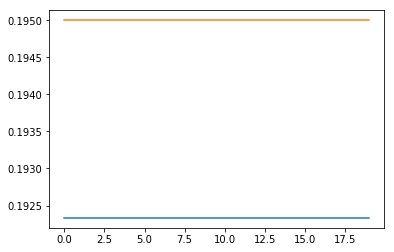

In [25]:
plt.plot(train_history)
plt.plot(val_history)

In [ ]:
class Layer:
    def forward(self, x):
        result = ... # промежуточные вычисления
        self.x = x # сохраняем значения, которые нам
                   # понадобятся при обратном проходе
        return result
    
    def backward(self, grad):
        dx = ... # используем сохраненные значения, чтобы 
        dw = ... # вычислить градиент по x и по w
        self.w.grad += dw # аккумулируем градиент dw
        return dx

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [ ]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [ ]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [ ]:
data_size = 15
model = TwoLayerNet(hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [ ]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))